# CNN with a Trainable Embedding Layer - Multi-label study
## Redoing with 80/10/10 split data

In this, I use a 3-neuron sigmoid layer as the three sublabels are not unique.

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 5000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train_80_10_10.csv',
                                          'cleaned_contents',
                                          label_columns=['Gender_Stereotypes', 'Customary_Practices', 'Other_Factors'],
                                          val_filepath='../data/val_80_10_10.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17531
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1501
	95percentile : 3939
	99percentile : 7668
x_train shape: (647,5000)
y_train shape: (647, 3)
Is Multi-Label? True
81 test sequences
test sequence lengths:
	mean : 1510
	95percentile : 4141
	99percentile : 5507
x_test shape: (81,5000)
y_test shape: (81, 3)


## Build the model

In [5]:
def _build_cnn(maxlen, max_features, embed_dim, filters, kernels,
               dropout=0.1,
               loss_func='binary_crossentropy',
               activation = 'softmax', metrics=['accuracy'],
               verbose=1, optimizer='adam'):
    
    embedding_matrix = np.ones((max_features, 1))
    embedding_matrix[0] = 0

    # set up the model
    inp = tf.keras.layers.Input(shape=(maxlen,))
    x = tf.keras.layers.Embedding(max_features, embed_dim, input_length=maxlen, 
                                  trainable=True)(inp)
    x0 = tf.keras.layers.Conv1D(filters=filters,
                               kernel_size=kernels[0],
                               activation='relu')(x)
    x0 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[0] + 1)(x0)

    x1 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[1],
                                activation='relu')(x)
    x1 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[1] + 1)(x1)
    
    x2 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[2],
                                activation='relu')(x)
    x2 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[2] + 1)(x2)
    
    x3 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[3],
                                activation='relu')(x)
    x3 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[3] + 1)(x3)

    x4 = tf.keras.layers.Conv1D(filters=filters,
                                kernel_size=kernels[4],
                                activation='relu')(x)
    x4 = tf.keras.layers.MaxPool1D(pool_size=maxlen - kernels[4] + 1)(x4)

    x = tf.keras.layers.concatenate([x0, x1, x2, x3, x4])

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(3, activation=activation)(x)
    model = tf.keras.Model(inputs=inp, outputs=outputs)
    model.compile(loss=loss_func,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [6]:
model = _build_cnn(5000, 50000, 100, filters=32, kernels=[2, 3, 4, 5, 6], dropout=0.4, activation='sigmoid')
learner = ktrain.get_learner(model, train_data=train, val_data=test)

In [7]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5000, 100)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 4999, 32)     6432        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 32)     9632        embedding[0][0]                  
______________________________________________________________________________________________

## Define and train the model

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 647 samples
Epoch 1/5
647/647 [==============================] - 5s 8ms/sample - loss: 0.6973 - accuracy: 0.4930
Epoch 2/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.6964 - accuracy: 0.5064
Epoch 3/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.6565 - accuracy: 0.6589
Epoch 4/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.7347 - accuracy: 0.6785
Epoch 5/5
647/647 [==============================] - 3s 5ms/sample - loss: 0.7374 - accuracy: 0.6919


done.
Visually inspect loss plot and select learning rate associated with falling loss


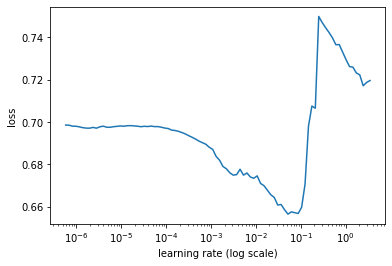

In [8]:
learner.lr_find(show_plot=True)

### Train

In [9]:
learner.autofit(0.001, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 647 samples, validate on 81 samples
Epoch 1/1024
647/647 [==============================] - 4s 7ms/sample - loss: 0.6509 - accuracy: 0.6538 - val_loss: 0.6132 - val_accuracy: 0.7078
Epoch 2/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.6054 - accuracy: 0.6945 - val_loss: 0.6015 - val_accuracy: 0.7078
Epoch 3/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5991 - accuracy: 0.6924 - val_loss: 0.6008 - val_accuracy: 0.7078
Epoch 4/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5985 - accuracy: 0.6899 - val_loss: 0.5981 - val_accuracy: 0.7078
Epoch 5/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5847 - accuracy: 0.6991 - val_loss: 0.5950 - val_accuracy: 0.7078
Epoch 6/1024
647/647 [==============================] - 3s 5ms/sample - loss: 0.5715 - accur

## Examine results

In [12]:
val_x = list(pd.read_csv('../data/val_80_10_10.csv')['cleaned_contents'])
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
y_hat = predictor.predict(list(val_x))


In [39]:
y_pa_gs = np.array([i[0][1] for i in y_hat])
y_pa_cp = np.array([i[1][1] for i in y_hat])
y_pa_of = np.array([i[2][1] for i in y_hat])

In [26]:
y_gs = np.array(pd.read_csv('../data/val_80_10_10.csv')['Gender_Stereotypes'], dtype='bool')
y_cp = np.array(pd.read_csv('../data/val_80_10_10.csv')['Customary_Practices'], dtype='bool')
y_of = np.array(pd.read_csv('../data/val_80_10_10.csv')['Other_Factors'], dtype='bool')

In [53]:
threshold = 0.5
y_hat_gs = y_pa_gs > threshold
y_hat_cp = y_pa_cp > threshold
y_hat_of = y_pa_of > threshold

print('----------------------------------------------')
print('Gender_Stereotypes')
print(classification_report(y_gs, y_hat_gs))
print('----------------------------------------------')
print('Customary_Practices')
print(classification_report(y_cp, y_hat_cp))
print('----------------------------------------------')
print('Other_Factors')
print(classification_report(y_of, y_hat_of))

----------------------------------------------
Gender_Stereotypes
              precision    recall  f1-score   support

       False       0.74      0.91      0.81        55
        True       0.62      0.31      0.41        26

    accuracy                           0.72        81
   macro avg       0.68      0.61      0.61        81
weighted avg       0.70      0.72      0.68        81

----------------------------------------------
Customary_Practices
              precision    recall  f1-score   support

       False       0.78      0.97      0.86        61
        True       0.60      0.15      0.24        20

    accuracy                           0.77        81
   macro avg       0.69      0.56      0.55        81
weighted avg       0.73      0.77      0.71        81

----------------------------------------------
Other_Factors
              precision    recall  f1-score   support

       False       0.71      0.98      0.82        56
        True       0.67      0.08      0.14

These results are very poor likely owing to the relatively small number of samples of each disaggregated trigger of gender disrimination.